# Hedging With Options

If the strike percents are changed, change the regression in hedge_downside function and the headers in returned df

In [62]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import data_functions as dat_func, visualizations as vis
import yfinance as yf
from datetime import datetime
import QuantLib as ql
from scipy.optimize import minimize
import warnings

import patsy
import statsmodels.api as sm

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Get stock data

In [80]:
start_date,end_date="2023-04-19",'2024-04-19'
start_date,end_date=pd.to_datetime(start_date),pd.to_datetime(end_date)
trade_dates=dat_func.get_trading_days(start_date,end_date)

#tickers = ['XOM','FI','ATKR','VICI','STLD','GOOG','BN','BKNG','SBUX','NKE']
weights_dict = pd.read_pickle('data/full_sim_port_weights.pkl')
ticker_list = list(weights_dict.keys()) 
ex_stock='NKE'
stock_df=dat_func.get_price_df(ticker_list,start_date,end_date)
returns_df=dat_func.get_log_returns(stock_df)

[*********************100%%**********************]  11 of 11 completed


In [81]:
# Option Pricing
def price_option(S0,vol,strike,risk_free_rate,expire,call=True):
        if call:
            option = ql.EuropeanOption( ql.PlainVanillaPayoff(ql.Option.Call, strike),
                         ql.EuropeanExercise(expire))
        else:
            option = ql.EuropeanOption( ql.PlainVanillaPayoff(ql.Option.Put, strike),
                         ql.EuropeanExercise(expire))
        u = ql.SimpleQuote(S0)      # set todays value of the underlying
        r = ql.SimpleQuote(risk_free_rate)       # set risk-free rate 
        sigma = ql.SimpleQuote(vol)   # set volatility
        riskFreeCurve = ql.FlatForward(0, ql.TARGET(), ql.QuoteHandle(r), ql.Actual360())
        volatility = ql.BlackConstantVol(0, ql.TARGET(), ql.QuoteHandle(sigma), ql.Actual360())
        # The Model
        process = ql.BlackScholesProcess( ql.QuoteHandle(u), 
                                       ql.YieldTermStructureHandle(riskFreeCurve),
                                       ql.BlackVolTermStructureHandle(volatility))
        engine = ql.AnalyticEuropeanEngine(process)
        # The Result
        option.setPricingEngine(engine)
        return option.NPV()

In [82]:
# Get df of option prices
def create_options(stock_df, stocks, strike_pcts,risk_free_rate, today,expire):
    """
    Returns price of 1 option on the stock 
    """
    dfs_to_concat = []
    ql.Settings.instance().evaluationDate = today
    for stock in stocks:
        S0 = stock_df[stock][-1]
        vol=returns_df.std()[stock]*np.sqrt(252)
        
        strikes = [pct * S0 for pct in strike_pcts]
        #strikes = [S0*0.9, S0, S0*1.1]
        
        price_at_strike = []
        
        for strike in strikes:
            call = price_option(S0,vol,strike,risk_free_rate,expire,call=True)
            price_at_strike.append(call)
            put = price_option(S0,vol,strike,risk_free_rate,expire,call=False)
            price_at_strike.append(put)
        
        df_row = pd.DataFrame({
                'Ticker': [stock],
                'call_90_pct': [price_at_strike[0]],
                'call_atm': [price_at_strike[2]],
                'call_110_pct': [price_at_strike[4]],
                'put_90_pct': [price_at_strike[1]],
                'put_atm': [price_at_strike[3]],
                'put_110_pct': [price_at_strike[5]],
            })
            
        dfs_to_concat.append(df_row)
    
    output = pd.concat(dfs_to_concat, ignore_index=True)  
    return output

## Get option prices for tickers

In [87]:
#tickers = ['XOM','FI','ATKR','VICI','STLD','GOOG','BN','BKNG','SBUX','NKE']
fred,poly=dat_func.connect_apis()
risk_free_rate=fred.get_series('GS10').iloc[-1]/100
today = ql.Date(19, 4, 2024)
expire = ql.Date(19, 4, 2025)
strike_pcts = [0.9, 1, 1.1]
price_of_options_df = create_options(stock_df, ticker_list, strike_pcts,risk_free_rate, today,expire)
price_of_options_df

,Ticker,call_90_pct,call_atm,call_110_pct,put_90_pct,put_atm,put_110_pct
0,XLC,12.422284,7.211707,3.722362,1.365489,3.854157,8.064058
1,NKE,17.890424,12.596719,8.593383,4.715844,8.596074,13.766673
2,XLP,10.408829,4.826112,1.585594,0.264375,1.745607,5.569039
3,XLE,15.072253,9.227436,5.179595,2.159129,5.306186,10.250219
4,JPM,27.997504,16.231969,8.359713,3.056072,8.658156,18.153519
5,JNJ,21.807504,11.954297,5.591787,1.752528,5.864325,13.466817
6,CAT,64.772731,44.667665,29.660262,15.697629,29.765328,48.930688
7,LIN,68.332872,39.036765,19.617351,6.900579,20.381994,43.740103
8,XLRE,5.675845,3.424587,1.879759,0.757739,1.931135,3.810963
9,XLK,30.801529,18.243020,9.725802,3.750568,10.028619,20.347961


## Get Portfolio Weights

In [84]:
returns_df=dat_func.get_log_returns(stock_df)
# vis.plot_cumulative_returns(returns_df)
# init_weights,init_ret,init_std=dat_func.get_init_port(returns_df,risk_free_rate,leverage_limit=1)
# init_weights=init_weights.round(3)
# weight_dict = dict(zip(returns_df.columns,init_weights))
# print('Initial Port Returns:',init_ret)
# print('Initial Port Volatility:',init_std)
# print('Initial Port Sharpe:',(init_ret-risk_free_rate)/init_std)
# print('Optimal Weights:',dict(zip(returns_df.columns,init_weights)))

## Hedging

In [85]:
def hedge_downside(stock_df, stocks, weights, strike_pcts):
    """
    Returns how many of each put you should but for $1 in the position, taking into account long/short 
    """
    option_list = []
    for stock in stocks:
        long = weights[stock] >0.0  # If we are long the stock
        S0 = stock_df[stock][-1]
        
        gpc_gbm=dat_func.simulate_gbm(stock_df[stock][-1],returns_df.mean()[stock]*252,returns_df.std()[stock]*np.sqrt(252),1,N=100)
        
        if long:
            sim_min = np.min(gpc_gbm[:,-1])  # Get minimum value of stock from sim
            max_loss = round(sim_min - S0)
            loss = np.linspace(0,max_loss,abs(max_loss)+1)  # max loss to 0 by 1
            stock_price = S0 + loss # stock prices for same loss
            portfolio_value = pd.DataFrame({'stock':stock_price, 'loss':loss*-1})
        else:
            sim_max = np.max(gpc_gbm[:,-1])  # Get minimum value of stock from sim
            max_loss = round(S0 - sim_max)
            loss = np.linspace(0,max_loss,abs(max_loss)+1)  # max loss to 0 by 1
            stock_price = S0 - loss  # stock prices for same loss
            portfolio_value = pd.DataFrame({'stock':stock_price, 'loss':loss*-1})
            
        portfolio_value['put_atm'] = np.maximum(S0 - portfolio_value['stock'],0)
        portfolio_value['put_90_pct'] = np.maximum(S0 - portfolio_value['stock']*0.9,0)
        portfolio_value['put_110_pct'] = np.maximum(S0 - portfolio_value['stock']*1.1,0)
        portfolio_value['call_atm'] = np.maximum(portfolio_value['stock']-S0,0)
        portfolio_value['call_90_pct'] = np.maximum(portfolio_value['stock']*0.9 - S0,0)
        portfolio_value['call_110_pct'] = np.maximum(portfolio_value['stock']*1.1 - S0,0)
        
        y, X = patsy.dmatrices('loss ~ put_atm + put_90_pct + put_110_pct + call_atm + call_90_pct + call_110_pct', portfolio_value)
        linear_model = sm.OLS(y, X)
        results = linear_model.fit()
        option_list.append([stock] + list(results.params[1:]))
        
        if stock == 'XOM':
            port_val = portfolio_value.copy()
            port_val['put_atm'] = port_val['put_atm'] * results.params[1]
            port_val['put_90_pct'] = port_val['put_90_pct']* results.params[2]
            port_val['put_110_pct'] = port_val['put_110_pct'] * results.params[3]
            port_val['call_atm'] = port_val['call_atm'] * results.params[4]
            port_val['call_90_pct'] = port_val['call_90_pct'] * results.params[5]
            port_val['call_110_pct'] = port_val['call_110_pct'] * results.params[6]
            port_val['option_total'] = port_val['put_atm'] + port_val['put_90_pct'] + port_val['put_110_pct'] + port_val['call_atm']
            port_val['option_total'] = port_val['option_total'] + port_val['call_90_pct'] + port_val['call_110_pct']
            port_val['together'] = port_val['option_total'] + port_val['loss'] * -1
            plt.plot(port_val['stock'], port_val['loss'] * -1)
            plt.plot(port_val['stock'], port_val['option_total'])
            plt.plot(port_val['stock'], port_val['together'])
            plt.xlabel('Stock Price')
            plt.legend(['Stock Loss', 'Option Gain', 'together'])

    df = pd.DataFrame(option_list, columns=['Ticker', 'put_atm', 'put_90_pct', 'put_110_pct', 'call_atm', 'call_90_pct', 'call_110_pct'])
    
    return df

In [86]:
#tickers = ['XOM','FI','ATKR','VICI','STLD','GOOG','BN','BKNG','SBUX','NKE']
strike_pcts = [0.9, 1, 1.1]
hedge_downside(stock_df, ticker_list, weights_dict, strike_pcts)

,Ticker,put_atm,put_90_pct,put_110_pct,call_atm,call_90_pct,call_110_pct
0,XLC,3.333163e-01,0.333060,0.000000,0.000000,0.000000,-0.333572
1,NKE,4.284631e-01,0.286364,0.285281,0.000000,0.000000,-0.285281
2,XLP,9.034626e-17,-0.284173,0.000000,0.427945,0.284173,0.287544
3,XLE,4.284588e-01,0.286390,0.285264,0.000000,0.000000,-0.285264
4,JPM,4.285411e-01,0.285897,0.285593,0.000000,0.000000,-0.285593
5,JNJ,4.285245e-01,0.285996,0.285527,0.000000,0.000000,-0.285527
6,CAT,4.285636e-01,0.285761,0.285683,0.000000,0.000000,-0.285683
7,LIN,1.965618e-16,-0.285672,0.000000,0.428554,0.285672,0.285765
8,XLRE,4.278287e-01,0.290171,0.282743,0.000000,0.000000,-0.282743
9,XLK,4.285456e-01,0.285869,0.285611,0.000000,0.000000,-0.285611


In [132]:
long = weights_dict['XLE'] >0.0  # If we are long the stock


S0 = stock_df['XLE'][-1]
if long:
    price = price_of_options_df.query("Ticker == 'XLE'").reset_index().put_atm[0]
else:
    price = price_of_options_df.query("Ticker == 'XLE'").reset_index().call_atm[0]
    
gpc_gbm=dat_func.simulate_gbm(stock_df['XLE'][-1],returns_df.mean()['XLE']*252,returns_df.std()['XLE']*np.sqrt(252),1,N=1000)


#gpc_gbm
gpc_gbm -= price
gpc_gbm = gpc_gbm + np.maximum(S0 - gpc_gbm,0)

print(np.mean(gpc_gbm[:,-1]))

vis.plot_paths(gpc_gbm,f'{'XLE'} GBM',False)

105.18233985941657


In [311]:
def log_returns(a):
    return np.diff(np.log(a)).cumsum()

def adjust_port_performance(ticker_list,weights_dict,stock_df,returns_df,price_of_options_df,log_returns, risk_free_rate):
    weights = [float(i) for i in list(weights_dict.values())]
    for func in [dat_func.simulate_gbm]:
        return_mean = []
        return_var = []
        total_portfolio = np.zeros((1000,253))
        for stock in ticker_list:
            long = weights_dict[stock] >0.0  # If we are long the stock
            S0 = stock_df[stock][-1]
            #print(S0)
            #print(long)
            if long:
                price = price_of_options_df.query("Ticker == @stock").reset_index().put_atm[0]
                gpc_gbm= func(stock_df[stock][-1],returns_df.mean()[stock]*252,returns_df.std()[stock]*np.sqrt(252),1,N=1000) 
                gpc_gbm = gpc_gbm + np.maximum(S0 - gpc_gbm,0)
                gpc_gbm[:,1:] = gpc_gbm[:,1:] - price
            else:
                price = price_of_options_df.query("Ticker == @stock").reset_index().call_atm[0]
                gpc_gbm= func(stock_df[stock][-1],returns_df.mean()[stock]*252,returns_df.std()[stock]*np.sqrt(252),1,N=1000)
                call_value = np.maximum(gpc_gbm - S0,0)
                gpc_gbm = (gpc_gbm - S0) * -1 + S0  # short pos
                gpc_gbm = gpc_gbm + call_value
                gpc_gbm[:,1:] = gpc_gbm[:,1:] - price
            
            total_portfolio += gpc_gbm * weights_dict[stock]
            #vis.plot_paths(gpc_gbm[:100,:],f'{stock} GBM',False)
            log_returns = np.diff(np.log(gpc_gbm[:, :-1]), axis=1)
            cumulative_log_return = np.cumsum(log_returns, axis=1)[:,-1]
            mean = cumulative_log_return.mean()
            var = np.var(cumulative_log_return, axis=0)
            return_mean.append(mean)
            return_var.append(var)
        
        #print(f"len: {len(return_mean)}")
        portfolio_mean = np.dot(np.array(return_mean), np.array(weights))
        portfolio_var = np.dot(np.array(return_var), np.array(weights))
        portfolio_std = np.sqrt(portfolio_var)
        sharpe = (portfolio_mean - risk_free_rate)/ portfolio_std
        vis.plot_paths(total_portfolio[:100,:],f'Portfolio Return - GBM',True)
            
    return sharpe

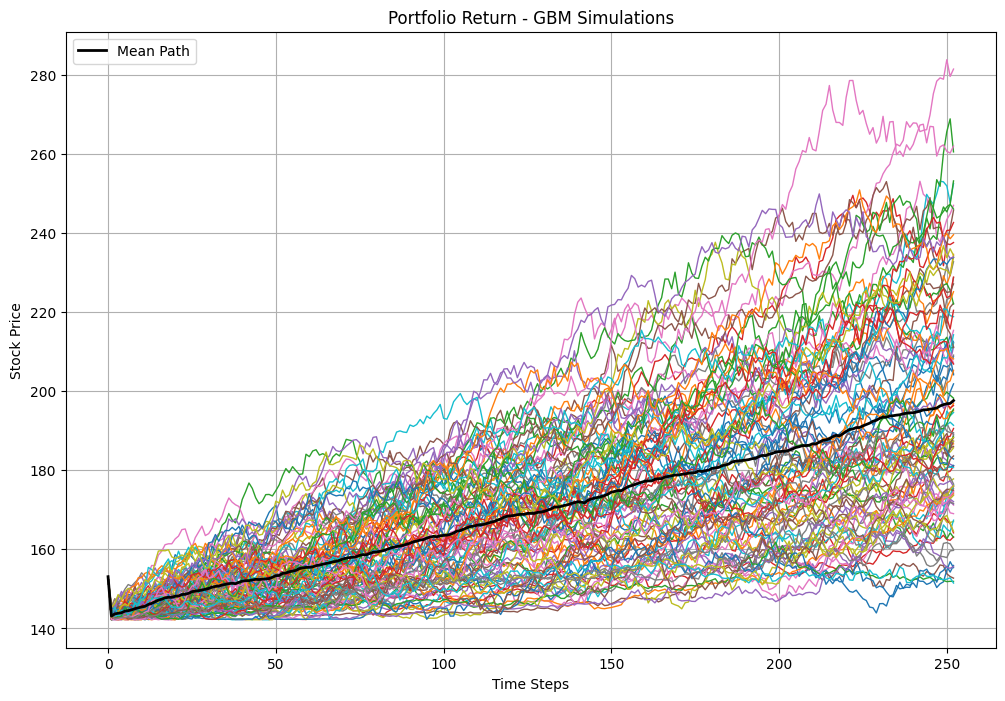

0.5397349581978953

In [312]:
adjust_port_performance(ticker_list,weights_dict,stock_df,returns_df,price_of_options_df,log_returns, risk_free_rate)

In [319]:
def log_returns(a):
    return np.diff(np.log(a)).cumsum()

def adjust_port_performance_merton(ticker_list,weights_dict,stock_df,returns_df,price_of_options_df,log_returns, risk_free_rate):
    weights = [float(i) for i in list(weights_dict.values())]
    for func in [dat_func.simulate_merton]:
        return_mean = []
        return_var = []
        total_portfolio = np.zeros((1000,253))
        for stock in ticker_list:
            long = weights_dict[stock] >0.0  # If we are long the stock
            S0 = stock_df[stock][-1]
            #print(S0)
            #print(long)
            if long:
                price = price_of_options_df.query("Ticker == @stock").reset_index().put_atm[0]
                gpc_lambda_,gpc_m,gpc_v=dat_func.estimate_merton_params(returns_df[stock])
                gpc_gbm= func(stock_df[stock][-1],returns_df.mean()[stock]*252,returns_df.std()[stock]*np.sqrt(252),1,gpc_lambda_,gpc_m,gpc_v,1/252,1000)
                gpc_gbm = gpc_gbm + np.maximum(S0 - gpc_gbm,0)
                gpc_gbm[:,1:] = gpc_gbm[:,1:] - price
            else:
                price = price_of_options_df.query("Ticker == @stock").reset_index().call_atm[0]
                gpc_lambda_,gpc_m,gpc_v=dat_func.estimate_merton_params(returns_df[stock])
                gpc_gbm= func(stock_df[stock][-1],returns_df.mean()[stock]*252,returns_df.std()[stock]*np.sqrt(252),1,gpc_lambda_,gpc_m,gpc_v,1/252,1000)
                call_value = np.maximum(gpc_gbm - S0,0)
                gpc_gbm = (gpc_gbm - S0) * -1 + S0  # short pos
                gpc_gbm = gpc_gbm + call_value
                gpc_gbm[:,1:] = gpc_gbm[:,1:] - price
            
            total_portfolio += gpc_gbm * weights_dict[stock]
            #vis.plot_paths(gpc_gbm[:100,:],f'{stock} GBM',False)
            log_returns = np.diff(np.log(gpc_gbm[:, :-1]), axis=1)
            cumulative_log_return = np.cumsum(log_returns, axis=1)[:,-1]
            mean = cumulative_log_return.mean()
            var = np.var(cumulative_log_return, axis=0)
            return_mean.append(mean)
            return_var.append(var)
        
        #print(f"len: {len(return_mean)}")
        portfolio_mean = np.dot(np.array(return_mean), np.array(weights))
        portfolio_var = np.dot(np.array(return_var), np.array(weights))
        portfolio_std = np.sqrt(portfolio_var)
        sharpe = (portfolio_mean - risk_free_rate)/ portfolio_std
        vis.plot_paths(total_portfolio[:100,:],f'Portfolio Return - Merton',True)
            
    return sharpe

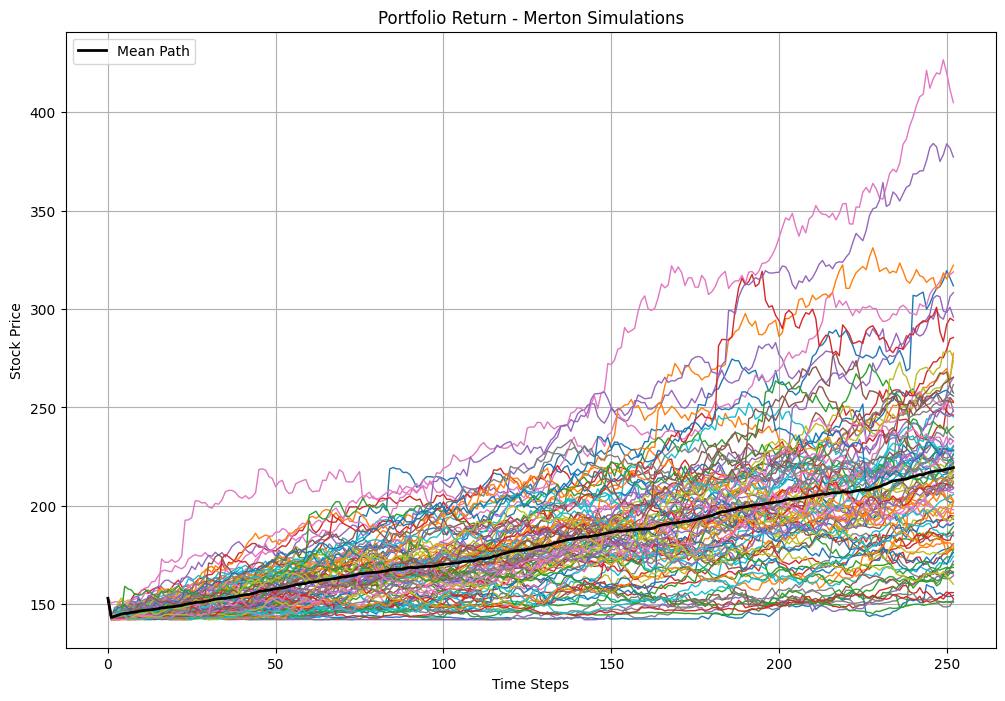

0.5355482864170673

In [320]:
adjust_port_performance_merton(ticker_list,weights_dict,stock_df,returns_df,price_of_options_df,log_returns, risk_free_rate)

In [333]:
def log_returns(a):
    return np.diff(np.log(a)).cumsum()

def adjust_port_performance_cev(ticker_list,weights_dict,stock_df,returns_df,price_of_options_df,log_returns, risk_free_rate):
    weights = [float(i) for i in list(weights_dict.values())]
    for func in [dat_func.simulate_cev]:
        return_mean = []
        return_var = []
        total_portfolio = np.zeros((1000,253))
        for stock in ticker_list:
            long = weights_dict[stock] >0.0  # If we are long the stock
            S0 = stock_df[stock][-1]
            #print(S0)
            #print(long)
            if long:
                price = price_of_options_df.query("Ticker == @stock").reset_index().put_atm[0]
                cev_ex_params=dat_func.estimate_cev_params(stock_series=stock_df[stock])
                gpc_gbm= func(stock_df[stock][-1],cev_ex_params[0]*252,cev_ex_params[1]*np.sqrt(252), gamma=cev_ex_params[2], T=1, N=1000)
                gpc_gbm = gpc_gbm + np.maximum(S0 - gpc_gbm,0)
                gpc_gbm[:,1:] = gpc_gbm[:,1:] - price
            else:
                price = price_of_options_df.query("Ticker == @stock").reset_index().call_atm[0]
                cev_ex_params=dat_func.estimate_cev_params(stock_series=stock_df[stock])
                gpc_gbm= func(stock_df[stock][-1],cev_ex_params[0]*252,cev_ex_params[1]*np.sqrt(252), gamma=cev_ex_params[2], T=1, N=1000)
                call_value = np.maximum(gpc_gbm - S0,0)
                gpc_gbm = (gpc_gbm - S0) * -1 + S0  # short pos
                gpc_gbm = gpc_gbm + call_value
                gpc_gbm[:,1:] = gpc_gbm[:,1:] - price
            
            total_portfolio += gpc_gbm * weights_dict[stock]
            #vis.plot_paths(gpc_gbm[:100,:],f'{stock} GBM',False)
            log_returns = np.diff(np.log(gpc_gbm[:, :-1]), axis=1)
            cumulative_log_return = np.cumsum(log_returns, axis=1)[:,-1]
            mean = cumulative_log_return.mean()
            var = np.var(cumulative_log_return, axis=0)
            return_mean.append(mean)
            return_var.append(var)
        
        #print(f"len: {len(return_mean)}")
        portfolio_mean = np.dot(np.array(return_mean), np.array(weights))
        portfolio_var = np.dot(np.array(return_var), np.array(weights))
        portfolio_std = np.sqrt(portfolio_var)
        sharpe = (portfolio_mean - risk_free_rate)/ portfolio_std
        vis.plot_paths(total_portfolio[:100,:],f'Portfolio Return - CEV',True)
            
    return sharpe

Estimated XLC CEV Parameters: mu=0.0012330686804840952, std=0.7290676209649539, gamma=0.0
Estimated NKE CEV Parameters: mu=-0.0005159603155615044, std=0.00020363561989210702, gamma=1.9540748950359346
Estimated XLP CEV Parameters: mu=-1.98609551056835e-05, std=0.46882474101957605, gamma=0.0
Estimated XLE CEV Parameters: mu=0.0004484805320552547, std=1.006687408482076, gamma=0.0
Estimated JPM CEV Parameters: mu=0.0011667671350239, std=0.004279177235642103, gamma=1.1800972417116413
Estimated JNJ CEV Parameters: mu=-0.00020329784181658802, std=5.997707388768725e-05, gamma=2.0
Estimated CAT CEV Parameters: mu=0.0019510493999124322, std=2.4499356181086043, gamma=0.10434265678743089
Estimated LIN CEV Parameters: mu=0.0008649337470906053, std=0.20180587725917437, gamma=0.5021241303116254
Estimated XLRE CEV Parameters: mu=-0.00012692173138083347, std=0.422599303298303, gamma=0.0
Estimated XLK CEV Parameters: mu=0.001073213232667465, std=0.17250115512511116, gamma=0.4724094568292567
Estimated XL

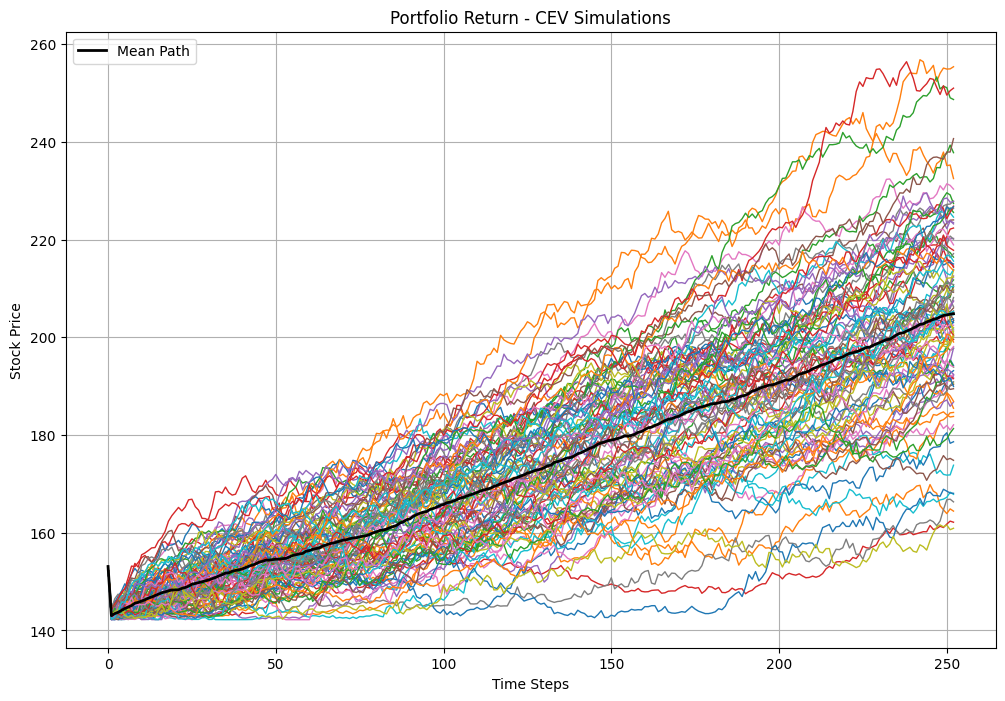

0.7175812268126515

In [334]:
adjust_port_performance_cev(ticker_list,weights_dict,stock_df,returns_df,price_of_options_df,log_returns, risk_free_rate)

In [335]:
def log_returns(a):
    return np.diff(np.log(a)).cumsum()

def adjust_port_performance_heston(ticker_list,weights_dict,stock_df,returns_df,price_of_options_df,log_returns, risk_free_rate):
    weights = [float(i) for i in list(weights_dict.values())]
    for func in [dat_func.simulate_heston]:
        return_mean = []
        return_var = []
        total_portfolio = np.zeros((1000,253))
        for stock in ticker_list:
            long = weights_dict[stock] >0.0  # If we are long the stock
            S0 = stock_df[stock][-1]
            #print(S0)
            #print(long)
            if long:
                price = price_of_options_df.query("Ticker == @stock").reset_index().put_atm[0]
                ex_heston_param=dat_func.estimate_heston_params(stock,end_date,stock_df,risk_free_rate)
                gpc_gbm= func(ex_heston_param, stock_df[stock][-1], risk_free_rate)
                gpc_gbm = gpc_gbm.to_numpy()
                gpc_gbm = gpc_gbm + np.maximum(S0 - gpc_gbm,0)
                gpc_gbm[:,1:] = gpc_gbm[:,1:] - price
            else:
                price = price_of_options_df.query("Ticker == @stock").reset_index().call_atm[0]
                ex_heston_param=dat_func.estimate_heston_params(stock,end_date,stock_df,risk_free_rate)
                gpc_gbm= func(ex_heston_param, stock_df[stock][-1], risk_free_rate)
                gpc_gbm = gpc_gbm.to_numpy()
                call_value = np.maximum(gpc_gbm - S0,0)
                gpc_gbm = (gpc_gbm - S0) * -1 + S0  # short pos
                
                gpc_gbm = gpc_gbm + call_value
                gpc_gbm[:,1:] = gpc_gbm[:,1:] - price
            
            total_portfolio += gpc_gbm * weights_dict[stock]
            #vis.plot_paths(gpc_gbm[:100,:],f'{stock} GBM',False)
            log_returns = np.diff(np.log(gpc_gbm[:, :-1]), axis=1)
            cumulative_log_return = np.cumsum(log_returns, axis=1)[:,-1]
            mean = cumulative_log_return.mean()
            var = np.var(cumulative_log_return, axis=0)
            return_mean.append(mean)
            return_var.append(var)
        
        #print(f"len: {len(return_mean)}")
        portfolio_mean = np.dot(np.array(return_mean), np.array(weights))
        portfolio_var = np.dot(np.array(return_var), np.array(weights))
        portfolio_std = np.sqrt(portfolio_var)
        sharpe = (portfolio_mean - risk_free_rate)/ portfolio_std
        vis.plot_paths(total_portfolio[:100,:],f'Portfolio Return - Heston',True)
            
    return sharpe

Calibrated XLC parameters: theta=0.5996981909025619, kappa=0.3510719280200092, sigma=0.45928247080442325, rho=-0.999999010991477, v0=0.008948957208565029
Calibrated NKE parameters: theta=1.385257235075611, kappa=26.531173125868488, sigma=2.3641854220462006, rho=-0.6100876405895829, v0=4.681776420202798e-09
Calibrated XLP parameters: theta=0.2793255882710703, kappa=7.516339702052907, sigma=0.6591262080570448, rho=-0.9999972822592618, v0=0.010936891786124104
Calibrated XLE parameters: theta=0.038705918060440034, kappa=0.2617581351334027, sigma=0.7662378058022319, rho=-0.9998752628241888, v0=0.017179604862522364
Calibrated JPM parameters: theta=0.14395983443472707, kappa=1.481287899584175, sigma=0.6068905459405262, rho=-0.9999720731353814, v0=0.011672003790429696
Calibrated JNJ parameters: theta=0.8297598746840891, kappa=1.3107954272737363e-06, sigma=5.456736673220301, rho=-0.9940903249782137, v0=0.9224407089239262
Calibrated CAT parameters: theta=0.12505704502882334, kappa=2.781218516549

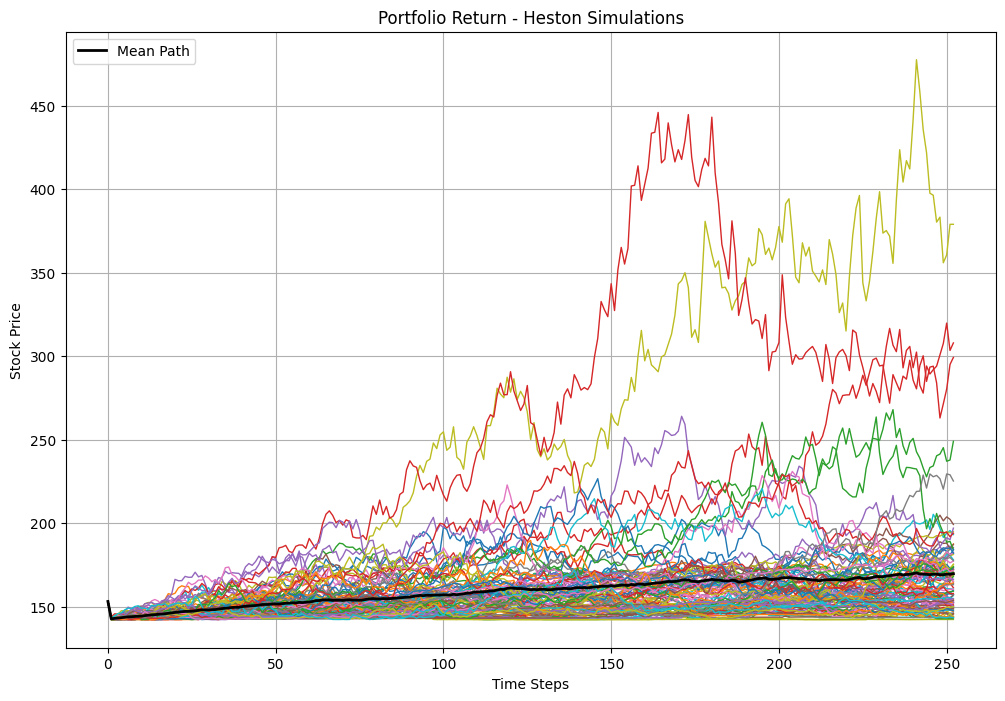

0.1069178885815895

In [336]:
adjust_port_performance_heston(ticker_list,weights_dict,stock_df,returns_df,price_of_options_df,log_returns, risk_free_rate)